In [1]:
from qubecalib import Qube, PortFunc, PortNo, Lane
from qubecalib.meas import SimpleSendRecvProto
import qubecalib.meas as meas
qube = Qube(config_file_name='qube_riken_1-07.yml')
qube.config

{'bitfile': '0d6045.bit',
 'ipfpga': '10.1.0.25',
 'iplsi': '10.5.0.25',
 'macfpga': '00-0A-35-0D-60-45',
 'maclsi': '00-1B-1A-EE-01-24',
 'type': 'A'}

In [2]:
print(qube.ad9082[0].get_jesd_status())
print(qube.ad9082[1].get_jesd_status())
['{}: {}'.format(k, v.status) for k, v in qube.port.items()]

[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]
[['0x55E', '0xE0'], ['0x5BB', '0x01'], ['0x62E', '0x01'], ['pll_status', '0x01'], ['0x728', '0x0B']]


['0: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive',
 '1: RF = 9000.000 MHz LO =  8000    MHz IF = 1000.000 MHz ',
 '5: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '6: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '7: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '8: RF = 10000.000 MHz LO = 11000    MHz IF = 1000.000 MHz LSB/USB: LSB MODE AWG: Inactive',
 '12: RF = 10000.000 MHz LO =  9000    MHz IF = 1000.000 MHz ',
 '13: RF = 10000.000 MHz LO =  9000    MHz IF = 1000.000 MHz LSB/USB: USB MODE AWG: Inactive']

In [3]:
o = SimpleSendRecvProto(
    duration = 40e-6,
    wait_words = 0,
    readin_port = qube[PortFunc.Readin1],
    readout_awg = qube.awg[PortFunc.Readout1],
)

In [4]:
o.capture_delay = 0.85e-6
o.additional_captue_length = 0.2e-6
o.repeats = 3

a = qube.awg[PortFunc.Readout1]
w = o.new_sequence(a)
o.wave_property[a].mhz = 0

a = qube.awg[PortFunc.Ctrl2][Lane.L0]
w = o.new_sequence(a)
o.wave_property[a].mhz = 0
o.trigger = a

a = qube.awg[PortFunc.Ctrl2][Lane.L1]
w = o.new_sequence(a)
o.wave_property[a].mhz = 0

In [5]:
import math
def truncated_frequency(mhz):
    MAGIC_FREQ = 15.625
    return math.floor(mhz // MAGIC_FREQ) * MAGIC_FREQ

In [6]:
w = o.sequence[qube.awg[PortFunc.Readout1]]
t = w.timeline
w.iq[:] = 0
w.iq[(500e-9 <= t) & (t < 900e-9)] = 1.0 + 1j * 0.0

wc0 = o.new_sequence()
wc0.iq[:] = 0
wc0.iq[(100e-9 <= t) & (t < 200e-9)] = 1.0 + 1j * 0.0

wc10 = o.new_sequence()
wc10.iq[:] = 0
wc10.iq[(200e-9 <= t) & (t < 300e-9)] = 1.0 + 1j * 0.0

wc11 = o.new_sequence()
wc11.iq[:] = 0
wc11.iq[(200e-9 <= t) & (t < 300e-9)] = 1.0 + 1j * 0.0

wt00 = o.new_sequence()
wt00.iq[:] = 0
wt00.iq[(300e-9 <= t) & (t < 400e-9)] = 1.0 + 1j * 0.0

wt01 = o.new_sequence()
wt01.iq[:] = 0
wt01.iq[(300e-9 <= t) & (t < 400e-9)] = 1.0 + 1j * 0.0

wt02 = o.new_sequence()
wt02.iq[:] = 0
wt02.iq[(300e-9 <= t) & (t < 400e-9)] = 1.0 + 1j * 0.0

# Wave Sequence を アサイン
o.assign(qube.awg[PortFunc.Ctrl2][Lane.L0], wc0)
o.assign(qube.awg[PortFunc.Ctrl2][Lane.L1], wc10)
o.assign(qube.awg[PortFunc.Ctrl3][Lane.L0], wt00)


In [8]:
p = PortFunc.Readout1 # ポートの選択
cnco_mhz, awg_mhz = qube[p].set_freq(10000, 9000) # 周波数の設定 (Coarse NCO)
qube[PortFunc.Readin1].adc.cnco.freq = cnco_mhz
#qube[PortFunc.Readin1].adc.nco.lsi.set_nco(freq=0*15.625*1e+6, ch=5, adc_mode=True, fine_mode=True)
#qube[PortFunc.Readin1].dac.fnco[Lane.L1]
o.wave_property[qube.awg[p]].mhz = awg_mhz # AWG の変調周波数 (-200MHz ~ +200MHz ぐらいが実用範囲？)
qube[p].vatt = 0x800 # 出力の設定
print('AWG Frequency (Readout1) {} MHz'.format(awg_mhz), flush=True)

p = PortFunc.Ctrl2
nco_mhz, awg_mhz = qube[p].set_freq(10000, 11000)
o.wave_property[qube.awg[p][Lane.L0]].mhz = awg_mhz
o.wave_property[qube.awg[p][Lane.L1]].mhz = awg_mhz
qube[p].vatt = 0x800
print('AWG Frequency (Ctrl2) {} MHz'.format(awg_mhz), flush=True)
#qube[p].dac.nco.lsi.set_nco(freq=-0*15.625*1e+6, ch=3, adc_mode=False, fine_mode=True)
fnco_mhz = qube[p].set_fnco_mhz(20, lane=1)
print(fnco_mhz)

p = PortFunc.Ctrl3
nco_mhz, awg_mhz = qube[p].set_freq(10000, 11000)
o.wave_property[qube.awg[p][Lane.L0]].mhz = awg_mhz
qube[p].vatt = 0x800
print('AWG Frequency (Ctrl3) {} MHz'.format(awg_mhz), flush=True)

['{}: {}'.format(k, v.status) for k, v in qube.port.items()]

AWG Frequency (Readout1) 15.625 MHz
AWG Frequency (Ctrl2) -15.625 MHz


TypeError: set_fnco_mhz() missing 1 required positional argument: 'lane'

ValueError: The number of elements in the capture unit 0's integration result vector is too large.  (max = 4096, setting = 5133)

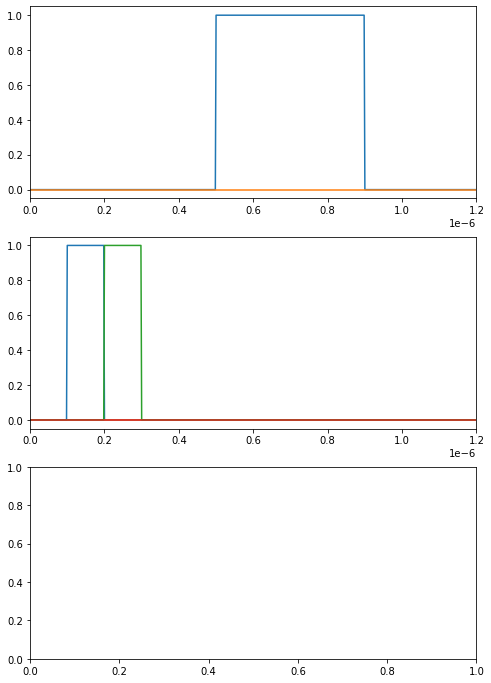

In [111]:
from e7awgsw import CaptureUnit
import numpy as np
o.capture_delay = 0.85e-6 # 冷凍機内へ打ち込んだ信号の応答が帰ってくるまでの遅延のための待機時間

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3,1, figsize=(8,12))

awg = qube.awg[PortFunc.Readout1]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
ax[0].plot(t,np.real(a))
ax[0].plot(t,np.imag(a))
ax[0].set_xlim(0, 1.2e-6)
awg = qube.awg[PortFunc.Ctrl2][Lane.L0]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
ax[1].plot(t,np.real(a))
ax[1].plot(t,np.imag(a))
ax[1].set_xlim(0, 1.2e-6)
awg = qube.awg[PortFunc.Ctrl2][Lane.L1]
a = np.array(o.sequence[awg].iq)
t = np.array(o.sequence[awg].timeline)
ax[1].plot(t,np.real(a))
ax[1].plot(t,np.imag(a))
ax[1].set_xlim(0, 1.2e-6)

# Wave Sequence を 再アサイン
# o.assign(qube.awg[PortFunc.Ctrl2][Lane.L0], wc0)
# o.assign(qube.awg[PortFunc.Ctrl2][Lane.L1], wc10)
# o.assign(qube.awg[PortFunc.Ctrl3][Lane.L0], wt00)
d = o.start()

a = d[CaptureUnit.U0]
b, t = o.downconv(a, qube.awg[PortFunc.Readout1])
ax[2].plot(t, np.real(b) / np.max(np.abs(b)))
ax[2].plot(t, np.imag(b) / np.max(np.abs(b)))
ax[2].set_xlim(0, 1.2e-6)

# a = d[CaptureUnit.U1]
# b, t = o.downconv(a, qube.awg[PortFunc.Readout1])
# ax[3].plot(t, np.real(b) / np.max(np.abs(b)))
# ax[3].plot(t, np.imag(b) / np.max(np.abs(b)))
# ax[3].set_xlim(0, 1.2e-6)

# a = d[CaptureUnit.U2]
# b, t = o.downconv(a, qube.awg[PortFunc.Readout1])
# ax[4].plot(t, np.real(b) / np.max(np.abs(b)))
# ax[4].plot(t, np.imag(b) / np.max(np.abs(b)))
# ax[4].set_xlim(0, 1.2e-6)

# a = d[CaptureUnit.U3]
# b, t = o.downconv(a, qube.awg[PortFunc.Readout1])
# ax[5].plot(t, np.real(b) / np.max(np.abs(b)))
# ax[5].plot(t, np.imag(b) / np.max(np.abs(b)))
# ax[5].set_xlim(0, 1.2e-6)


In [112]:
import inspect
import e7awgsw
import qubelsi
print(inspect.getsource(e7awgsw.CaptureCtrl))

class CaptureCtrl(CaptureCtrlBase):

    # キャプチャモジュールが波形データを保存するアドレス
    __CAPTURE_ADDR = [
        0x10000000,  0x30000000,  0x50000000,  0x70000000,
        0x90000000,  0xB0000000,  0xD0000000,  0xF0000000]
    # キャプチャ RAM のワードサイズ (bytes)
    __CAPTURE_RAM_WORD_SIZE = 32 # bytes

    def __init__(
        self,
        ip_addr,
        *,
        validate_args = True,
        enable_lib_log = True,
        logger = get_null_logger()):
        """
        Args:
            ip_addr (string): キャプチャユニット制御モジュールに割り当てられた IP アドレス (例 '10.0.0.16')
            validate_args(bool):
                | True -> 引数のチェックを行う
                | False -> 引数のチェックを行わない
            enable_lib_log (bool):
                | True -> ライブラリの標準のログ機能を有効にする.
                | False -> ライブラリの標準のログ機能を無効にする.
            logger (logging.Logger): ユーザ独自のログ出力に用いる Logger オブジェクト
        """
        super().__init__(ip_addr, validate_args, enable_lib_log, logger)
        self.__reg_access = CaptureRegAccess(ip_addr, CAPTURE_